*Note: You are currently reading this using Google Colaboratory which is a cloud-hosted version of Jupyter Notebook. This is a document containing both text cells for documentation and runnable code cells. If you are unfamiliar with Jupyter Notebook, watch this 3-minute introduction before starting this challenge: https://www.youtube.com/watch?v=inN8seMm7UI*

---

In this challenge, you will predict healthcare costs using a regression algorithm.

You are given a dataset that contains information about different people including their healthcare costs. Use the data to predict healthcare costs based on new data.

The first two cells of this notebook import libraries and the data.

Make sure to convert categorical data to numbers. Use 80% of the data as the `train_dataset` and 20% of the data as the `test_dataset`.

`pop` off the "expenses" column from these datasets to create new datasets called `train_labels` and `test_labels`. Use these labels when training your model.

Create a model and train it with the `train_dataset`. Run the final cell in this notebook to check your model. The final cell will use the unseen `test_dataset` to check how well the model generalizes.

To pass the challenge, `model.evaluate` must return a Mean Absolute Error of under 3500. This means it predicts health care costs correctly within $3500.

The final cell will also predict expenses using the `test_dataset` and graph the results.

In [1]:
# Import libraries. You may or may not use all of these.
!pip install -q git+https://github.com/tensorflow/docs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

     |████████████████████████████████| 1.0MB 5.2MB/s 


In [2]:
# Import data
!wget https://cdn.freecodecamp.org/project-data/health-costs/insurance.csv
dataset = pd.read_csv('insurance.csv')
dataset.tail()

--2021-01-05 20:29:11--  https://cdn.freecodecamp.org/project-data/health-costs/insurance.csv
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 172.67.70.149, 104.26.2.33, 104.26.3.33, ...
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|172.67.70.149|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/csv]
Saving to: ‘insurance.csv’

insurance.csv           [ <=>                ]  49.09K  --.-KB/s    in 0.001s  

2021-01-05 20:29:11 (88.7 MB/s) - ‘insurance.csv’ saved [50264]



,age,sex,bmi,children,smoker,region,expenses
1333,50,male,31.0,3,no,northwest,10600.55
1334,18,female,31.9,0,no,northeast,2205.98
1335,18,female,36.9,0,no,southeast,1629.83
1336,21,female,25.8,0,no,southwest,2007.95
1337,61,female,29.1,0,yes,northwest,29141.36


               age          bmi     children      expenses
count  1338.000000  1338.000000  1338.000000   1338.000000
mean     39.207025    30.665471     1.094918  13270.422414
std      14.049960     6.098382     1.205493  12110.011240
min      18.000000    16.000000     0.000000   1121.870000
25%      27.000000    26.300000     0.000000   4740.287500
50%      39.000000    30.400000     1.000000   9382.030000
75%      51.000000    34.700000     2.000000  16639.915000
max      64.000000    53.100000     5.000000  63770.430000


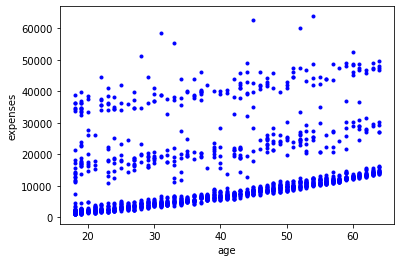

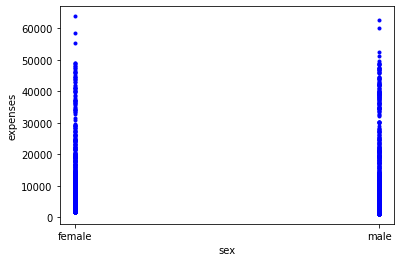

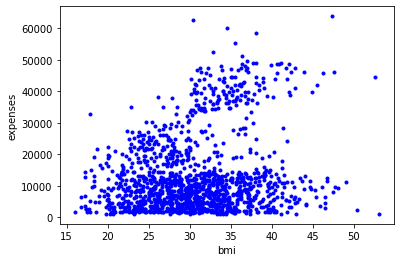

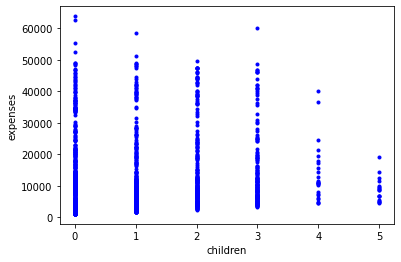

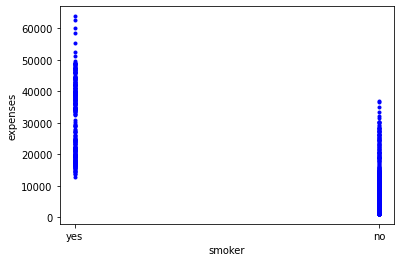

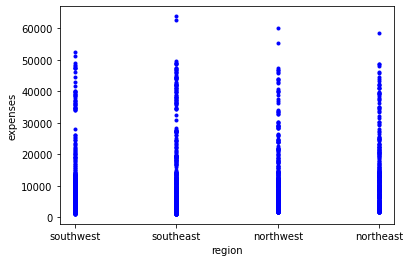

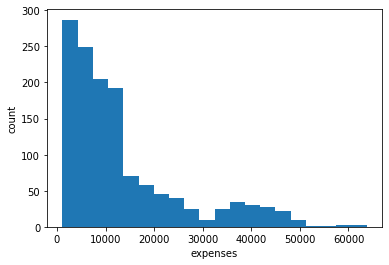

In [3]:
#print and plot some information about the data
print(dataset.describe())

for xname in ["age", "sex", "bmi", "children", "smoker", "region"]:
    x = dataset[xname]
    y = dataset["expenses"]
    plt.plot(x, y, "b.")
    plt.xlabel(xname)
    plt.ylabel("expenses")
    plt.show()

plt.hist(dataset["expenses"], bins=20)
plt.xlabel("expenses")
plt.ylabel("count")
plt.show()

In [4]:
# set some output options, so we can see the dataframe properly
pd.set_option("display.max_columns", 10)
pd.set_option("display.width", 200)

# turn string categories into integers
dataset_numeric = dataset.copy()
dataset_numeric["sex"] = dataset_numeric["sex"].map({"male": 0, "female": 1})
dataset_numeric["smoker"] = dataset_numeric["smoker"].map({"no": 0, "yes": 1})
dataset_numeric["region"] = dataset_numeric["region"].map({"southwest": 0, "southeast": 1, "northwest": 2, "northeast": 3})

print(dataset_numeric)
print(dataset)
print(dataset_numeric.describe())

      age  sex   bmi  children  smoker  region  expenses
0      19    1  27.9         0       1       0  16884.92
1      18    0  33.8         1       0       1   1725.55
2      28    0  33.0         3       0       1   4449.46
3      33    0  22.7         0       0       2  21984.47
4      32    0  28.9         0       0       2   3866.86
...   ...  ...   ...       ...     ...     ...       ...
1333   50    0  31.0         3       0       2  10600.55
1334   18    1  31.9         0       0       3   2205.98
1335   18    1  36.9         0       0       1   1629.83
1336   21    1  25.8         0       0       0   2007.95
1337   61    1  29.1         0       1       2  29141.36

[1338 rows x 7 columns]
      age     sex   bmi  children smoker     region  expenses
0      19  female  27.9         0    yes  southwest  16884.92
1      18    male  33.8         1     no  southeast   1725.55
2      28    male  33.0         3     no  southeast   4449.46
3      33    male  22.7         0     no  n

In [5]:
# split the dataset into train and test datasets
train_dataset = dataset_numeric.sample(frac=0.8, random_state=0)
test_dataset = dataset_numeric.drop(train_dataset.index)

print(train_dataset.describe())
print(test_dataset.describe())

# drop expenses and create train an test labels
train_labels = train_dataset.pop("expenses")
test_labels = test_dataset.pop("expenses")

print(train_dataset)
print(train_labels)

               age          sex          bmi     children       smoker       region      expenses
count  1070.000000  1070.000000  1070.000000  1070.000000  1070.000000  1070.000000   1070.000000
mean     39.036449     0.501869    30.737290     1.093458     0.199065     1.498131  13056.551654
std      14.142122     0.500230     6.065193     1.211364     0.399484     1.103399  11994.260172
min      18.000000     0.000000    16.000000     0.000000     0.000000     0.000000   1121.870000
25%      26.000000     0.000000    26.300000     0.000000     0.000000     1.000000   4565.995000
50%      39.000000     1.000000    30.500000     1.000000     0.000000     1.000000   9289.085000
75%      51.000000     1.000000    34.800000     2.000000     0.000000     2.000000  15826.112500
max      64.000000     1.000000    53.100000     5.000000     1.000000     3.000000  60021.400000
              age         sex         bmi    children      smoker      region      expenses
count  268.000000  268.000

In [6]:
# normalize training input, for stabilizing fitting
normalizer = keras.layers.experimental.preprocessing.Normalization()
normalizer.adapt(np.array(train_dataset))

# set up the model
model = keras.Sequential()
model.add(keras.Input(shape=(6,)))
model.add(normalizer)
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(units=1))

model.summary()

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.1),
    loss="mean_absolute_error", 
    metrics=["mae", "mse"]
)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 6)                 13        
_________________________________________________________________
dense (Dense)                (None, 64)                448       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 4,686
Trainable params: 4,673
Non-trainable params: 13
_________________________________________________________________


In [7]:
history = model.fit(train_dataset,
              train_labels,
              epochs=300,
              validation_split=0.2
)

Epoch 1/300
27/27 [==============================] - 1s 19ms/step - loss: 11322.5091 - mae: 11322.5091 - mse: 269331884.5714 - val_loss: 4531.4907 - val_mae: 4531.4907 - val_mse: 74785664.0000
Epoch 2/300
27/27 [==============================] - 0s 3ms/step - loss: 3612.8098 - mae: 3612.8098 - mse: 43522193.7143 - val_loss: 3430.6790 - val_mae: 3430.6790 - val_mse: 36798936.0000
Epoch 3/300
27/27 [==============================] - 0s 3ms/step - loss: 2956.8074 - mae: 2956.8074 - mse: 29076086.7143 - val_loss: 2995.1819 - val_mae: 2995.1819 - val_mse: 33870428.0000
Epoch 4/300
27/27 [==============================] - 0s 3ms/step - loss: 2922.4096 - mae: 2922.4096 - mse: 31529563.9286 - val_loss: 2993.7524 - val_mae: 2993.7524 - val_mse: 28302394.0000
Epoch 5/300
27/27 [==============================] - 0s 3ms/step - loss: 2727.1652 - mae: 2727.1652 - mse: 27767633.7143 - val_loss: 2613.0352 - val_mae: 2613.0352 - val_mse: 27157810.0000
Epoch 6/300
27/27 [==============================] 

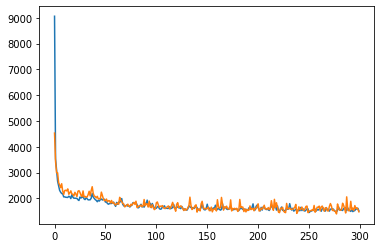

In [8]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.show()

9/9 - 0s - loss: 2071.2573 - mae: 2071.2573 - mse: 31109740.0000
Testing set Mean Abs Error: 2071.26 expenses
You passed the challenge. Great job!


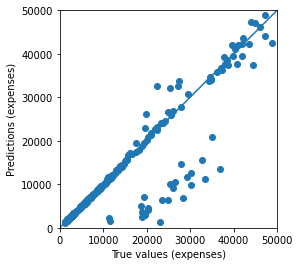

In [9]:
# RUN THIS CELL TO TEST YOUR MODEL. DO NOT MODIFY CONTENTS.
# Test model by checking how well the model generalizes using the test set.
loss, mae, mse = model.evaluate(test_dataset, test_labels, verbose=2)

print("Testing set Mean Abs Error: {:5.2f} expenses".format(mae))

if mae < 3500:
  print("You passed the challenge. Great job!")
else:
  print("The Mean Abs Error must be less than 3500. Keep trying.")

# Plot predictions.
test_predictions = model.predict(test_dataset).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True values (expenses)')
plt.ylabel('Predictions (expenses)')
lims = [0, 50000]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims,lims)
